# Steel Plant Image Clustering Using Autoencoders and TSNE

In [91]:
from keras.datasets import mnist
import numpy as np
np.random.seed(10)

In [92]:
!pwd

/home/jovyan/steel_plant_classification/Keras_Deep_Clustering


In [93]:
!pip install scikit-learn==0.22.2 # TODO This is a requirement so that code doesn't break

In [94]:
import copy
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import sklearn.metrics
from sklearn.model_selection import train_test_split
import metrics
import matplotlib.pyplot as plt
import scipy.stats

%matplotlib inline

Read in image data:

In [131]:
img_width, img_height = 256, 256 # TODO Was 214, 214
train_data_dir = '../data_nataliya_steel_cement_20200910/'

def read_images(img_width=img_width, img_height=img_height, train_data_dir=train_data_dir, augment_data=True, n_batches=400):
    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_width, img_height) # TODO Was 3
    else:
        input_shape = (img_width, img_height, 1) # TODO Was 3
        
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=20, # NEW
        width_shift_range=0.1, # NEW
        height_shift_range=0.1, # NEW
    horizontal_flip=True)
    
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=16,
        class_mode='categorical',
        color_mode='grayscale', # TODO omit
        shuffle=False
    )
    
    train_generator.reset()
    
    if not augment_data:
        x = np.concatenate([train_generator.next()[0] for i in range(len(train_generator))])
        y = np.concatenate([train_generator.next()[1] for i in range(len(train_generator))])
        
        return input_shape, x, y, np.array(train_generator.filenames)
    
    n_batches = 400
    x = []
    y = []
    filenames = []
    i = 0
    for x_i, y_i in train_generator:
        if i >= n_batches:
            break

        x.append(x_i)
        y.append(y_i)

        i += 1
    
    return input_shape, np.concatenate(x), np.concatenate(y)

In [132]:
input_shape, x, y = read_images()

print('Dimensions of observations: {}'.format(x.shape))
print('Dimensions of target classes: {}'.format(y.shape))

Found 248 images belonging to 3 classes.
Dimensions of observations: (6200, 256, 256, 1)
Dimensions of target classes: (6200, 3)


In [133]:
assert(np.max(x) == 1.0)

Determine number of instances per class:

In [134]:
np.sum(y, axis=0)

array([   0., 3075., 3125.], dtype=float32)

Consider steel plants only:

In [138]:
x = x[y[:, 2] == 1]
y = y[y[:, 2] == 1]
y = y[:, -1]

In [139]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0)

In [140]:
def flatten_data(x):
    return x.reshape((x.shape[0], -1))

# Implement Autoencoders

In [141]:
def Autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


## Convolutional Autoencoder Variant 1
Use [`Conv2DTranspose`](https://keras.io/layers/convolutional/#conv2dtranspose) to reconstruct the image.

In [142]:
def autoencoderConv2D_1(input_shape=(img_width, img_height, 1), filters=[64, 128, 256, 20]): # TODO was [32, 64, 128, 128]
    input_img = Input(shape=input_shape)
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)

    x = Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2')(x)

    x = Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3')(x)

    x = Flatten()(x)
    encoded = Dense(units=filters[3], name='embedding')(x)
    x = Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu')(encoded)

    x = Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2]))(x)
    x = Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3')(x)

    x = Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1')(x)
    
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

## Convolutional Autoencoder Variant 2
Use [`UpSampling2D`](https://keras.io/layers/convolutional/#upsampling2d) to reconstruct the image.

In [143]:
def autoencoderConv2D_2(img_shape=(img_width, img_height, 1)):
    """
    Conv2D auto-encoder model.
    Arguments:
        img_shape: e.g. (28, 28, 1) for MNIST
    return:
        (autoencoder, encoder), Model of autoencoder and model of encoder
    """
    input_img = Input(shape=img_shape)
    # Encoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(input_img)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    shape_before_flattening = K.int_shape(x)
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional
    x = Flatten()(x)
    encoded = Dense(10, activation='relu', name='encoded')(x)

    # Decoder
    x = Dense(np.prod(shape_before_flattening[1:]),
                activation='relu')(encoded)
    # Reshape into an image of the same shape as before our last `Flatten` layer
    x = Reshape(shape_before_flattening[1:])(x)

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x) # TODO There was no same here
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='tanh', padding='same')(x)

    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


# Train Autoencoders

## Fully Connected Autoencoder

In [144]:
models = {}
models['fully_connected'] = {}

In [145]:
dims = [flatten_data(x_train).shape[-1], 500, 500, 2000, 20] # TODO Last param was 10, then 20
init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
pretrain_optimizer = SGD(lr=0.2, momentum=0.9) # TODO changed learning rate to 0.8, then 0.1
# pretrain_optimizer = Adam(learning_rate=0.001)
pretrain_epochs = 600
batch_size = 8 # TODO Was 256, then 16
save_dir = './'

models['fully_connected']['autoencoder'], models['fully_connected']['encoder'] = Autoencoder(dims, init=init)
models['fully_connected']['autoencoder'].compile(optimizer=pretrain_optimizer, loss='mse')

In [146]:
models['fully_connected']['autoencoder'].fit(flatten_data(x_train), flatten_data(x_train), batch_size=batch_size, validation_split=0.3, epochs=pretrain_epochs) #, callbacks=cb)
models['fully_connected']['autoencoder'].save_weights(save_dir + '/ae_weights.h5')

Epoch 1/600
137/137 [==============================] - 1s 9ms/step - loss: 0.1809 - val_loss: 0.1833
Epoch 2/600
137/137 [==============================] - 1s 7ms/step - loss: 0.1737 - val_loss: 0.1644
Epoch 3/600
137/137 [==============================] - 1s 7ms/step - loss: 0.1135 - val_loss: 0.0573
Epoch 4/600
137/137 [==============================] - 1s 7ms/step - loss: 0.0374 - val_loss: 0.0290
Epoch 5/600
137/137 [==============================] - 1s 7ms/step - loss: 0.0293 - val_loss: 0.0281
Epoch 6/600
137/137 [==============================] - 1s 7ms/step - loss: 0.0291 - val_loss: 0.0281
Epoch 7/600
137/137 [==============================] - 1s 7ms/step - loss: 0.0291 - val_loss: 0.0281
Epoch 8/600
137/137 [==============================] - 1s 7ms/step - loss: 0.0291 - val_loss: 0.0281
Epoch 9/600
137/137 [==============================] - 1s 7ms/step - loss: 0.0291 - val_loss: 0.0281
Epoch 10/600
137/137 [==============================] - 1s 7ms/step - loss: 0.0291 - val_lo

In [147]:
models['fully_connected']['autoencoder'].load_weights(save_dir + '/ae_weights.h5')

## Convolutional Autoencoder Variant 1

In [148]:
from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
import numpy as np

In [149]:
conv1_n_units = [16, 32, 64, 128]

for n in conv1_n_units:
    key = 'conv1_' + str(n)
    models[key] = {}
    models[key]['autoencoder'], models[key]['encoder'] = autoencoderConv2D_1(filters=[32, 64, 128, n])
    models[key]['autoencoder'].summary()
    models[key]['autoencoder'].compile(optimizer='adam', loss='mse') # TODO Was adadelta, then adam

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 32)      832       
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 64)        51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 32, 32, 128)       73856     
_________________________________________________________________
flatten_5 (Flatten)          (None, 131072)            0         
_________________________________________________________________
embedding (Dense)            (None, 16)                2097168   
_________________________________________________________________
dense_5 (Dense)              (None, 131072)            2228224  

In [150]:
def train_conv1(x_train, pretrain_epochs=10, batch_size=8): # TODO Was 2500
    for n in conv1_n_units:
        key = 'conv1_' + str(n)
        models[key]['autoencoder'].fit(x_train, x_train, validation_split=0.3, batch_size=batch_size, epochs=pretrain_epochs)
        models[key]['autoencoder'].save_weights(save_dir+'/' + key + '_ae_weights.h5')

train_conv1(x_train)

Epoch 1/10
137/137 [==============================] - 25s 183ms/step - loss: 0.0460 - val_loss: 0.0286
Epoch 2/10
137/137 [==============================] - 2s 11ms/step - loss: 0.0275 - val_loss: 0.0251
Epoch 3/10
137/137 [==============================] - 2s 11ms/step - loss: 0.0240 - val_loss: 0.0229
Epoch 4/10
137/137 [==============================] - 2s 11ms/step - loss: 0.0219 - val_loss: 0.0213
Epoch 5/10
137/137 [==============================] - 2s 11ms/step - loss: 0.0206 - val_loss: 0.0212
Epoch 6/10
137/137 [==============================] - 2s 11ms/step - loss: 0.0192 - val_loss: 0.0194
Epoch 7/10
137/137 [==============================] - 2s 11ms/step - loss: 0.0186 - val_loss: 0.0191
Epoch 8/10
137/137 [==============================] - 2s 11ms/step - loss: 0.0180 - val_loss: 0.0187
Epoch 9/10
137/137 [==============================] - 2s 11ms/step - loss: 0.0174 - val_loss: 0.0188
Epoch 10/10
137/137 [==============================] - 2s 11ms/step - loss: 0.0172 - val_

In [151]:
def load_conv1_models():
    for n in conv1_n_units:
        key = 'conv1_' + str(n)
        models[key]['autoencoder'].load_weights(save_dir+'/' + key + '_ae_weights.h5')

load_conv1_models()

## Convolutional Autoencoder Variant 2

In [152]:
models['conv2'] = {}

In [153]:
models['conv2']['autoencoder'], models['conv2']['encoder'] = autoencoderConv2D_2()
models['conv2']['autoencoder'].summary()

pretrain_epochs = 20
batch_size = 8

models['conv2']['autoencoder'].compile(optimizer='adam', loss='mse') # TODO Was adadelta

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 8)         1160      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
flatten_9 (Flatten)          (None, 8192)              0         
_________________________________________________________________
encoded (Dense)              (None, 10)                81930     
_________________________________________________________________
dense_9 (Dense)              (None, 8192)              90112    

In [154]:
models['conv2']['autoencoder'].fit(x_train, x_train, batch_size=batch_size, validation_split=0.3, epochs=pretrain_epochs)
models['conv2']['autoencoder'].save_weights(save_dir+'/conv2_ae_weights.h5')

Epoch 1/20
137/137 [==============================] - 68s 493ms/step - loss: 0.0459 - val_loss: 0.0289
Epoch 2/20
137/137 [==============================] - 1s 7ms/step - loss: 0.0289 - val_loss: 0.0265
Epoch 3/20
137/137 [==============================] - 1s 7ms/step - loss: 0.0268 - val_loss: 0.0259
Epoch 4/20
137/137 [==============================] - 1s 7ms/step - loss: 0.0265 - val_loss: 0.0259
Epoch 5/20
137/137 [==============================] - 1s 7ms/step - loss: 0.0264 - val_loss: 0.0257
Epoch 6/20
137/137 [==============================] - 1s 8ms/step - loss: 0.0263 - val_loss: 0.0256
Epoch 7/20
137/137 [==============================] - 1s 7ms/step - loss: 0.0262 - val_loss: 0.0256
Epoch 8/20
137/137 [==============================] - 1s 7ms/step - loss: 0.0262 - val_loss: 0.0257
Epoch 9/20
137/137 [==============================] - 1s 7ms/step - loss: 0.0262 - val_loss: 0.0257
Epoch 10/20
137/137 [==============================] - 1s 7ms/step - loss: 0.0261 - val_loss: 0.0

In [155]:
models['conv2']['autoencoder'].load_weights(save_dir+'/conv2_ae_weights.h5')

### Visualise Original and Reconstructed Images

In [156]:
def compute_performance(x_train, x_test):
    for model_name, model in models.items():
        if 'conv' not in model_name:
            x_train_new = flatten_data(x_train)
            x_test_new = flatten_data(x_test)
        else:
            x_train_new = x_train
            x_test_new = x_test

        model['x_hat_train'] = model['autoencoder'].predict(x_train_new)
        model['x_hat_test'] = model['autoencoder'].predict(x_test_new)
        
        if 'conv' not in model_name:
            model['x_hat_train'] = np.reshape(model['x_hat_train'], (-1, ) + input_shape)
            model['x_hat_test'] = np.reshape(model['x_hat_test'], (-1,) + input_shape)
            
            x_train_new = x_train
            x_test_new = x_test

        model['mse_train'] = np.mean((x_train_new - model['x_hat_train']) ** 2)
        model['mse_test'] = np.mean((x_test_new - model['x_hat_test']) ** 2)
        
compute_performance(x_train, x_test)

In [157]:
models.keys()

dict_keys(['fully_connected', 'conv1_16', 'conv1_32', 'conv1_64', 'conv1_128', 'conv2'])

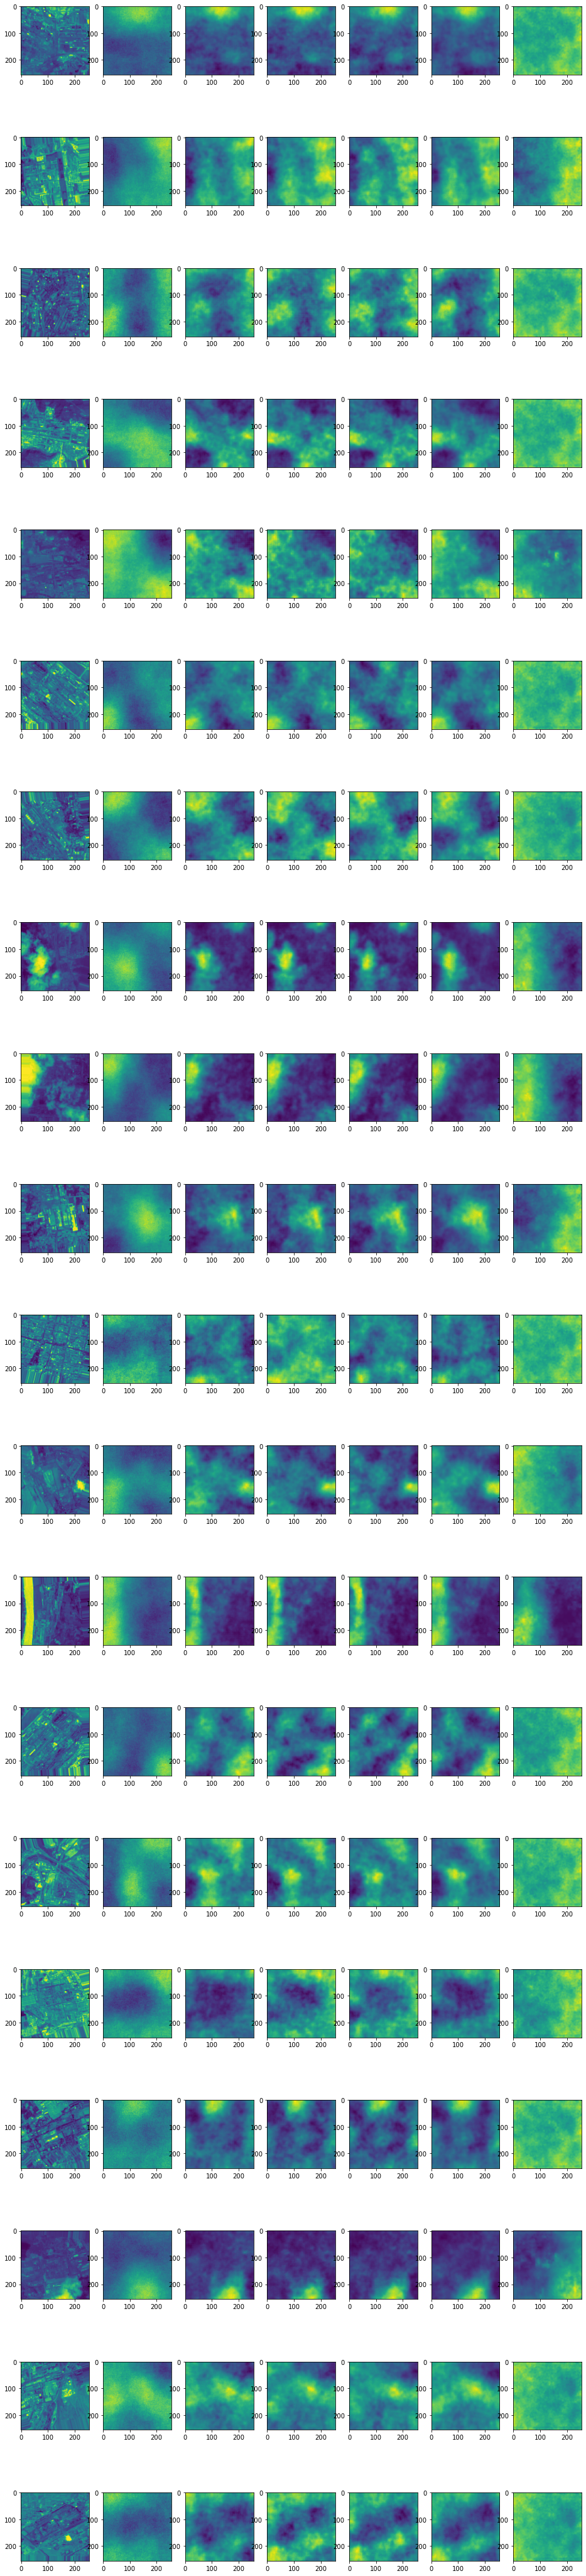

In [158]:
def plot_sample(models, n_pairs=20, figsize=(16, 76)):
    plt.figure(figsize=figsize)
    
    I = np.random.permutation(x_test.shape[0])[:n_pairs]

    n_models = len(models)
    n_cols = n_models + 1
    for i in range(n_pairs):
        plt.subplot(n_pairs, n_cols, i * n_cols + 1)
        plt.imshow(x_test[I[i]])
        
        for j, (model_name, model) in enumerate(models.items()):
            plt.subplot(n_pairs, n_cols, i * n_cols + 2 + j)
            plt.imshow(model['x_hat_test'][I[i]])
        
plot_sample(models)

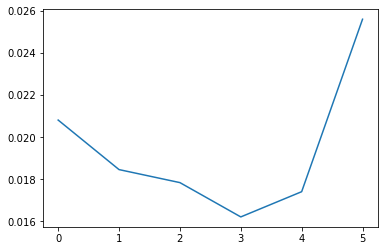

In [159]:
plt.plot([m['mse_test'] for _, m in models.items()])

## Build clustering model

### ClusteringLayer

In [29]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        
        return dict(list(base_config.items()) + list(config.items()))

### Step 2: deep clustering
Compute p_i by first raising q_i to the second power and then normalizing by frequency per cluster:

In [30]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    
    return (weight.T / weight.sum(1)).T

### Start training

In [249]:
def init_clusterer(n_clusters=8, key='conv1_64'):
    load_conv1_models()
    
    autoencoder = models[key]['autoencoder']
    encoder = models[key]['encoder']

    clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
    clustering_model = Model(inputs=encoder.input, outputs=clustering_layer)
    clustering_model.compile(optimizer='adadelta', loss='kld') # TODO Was adadelta
    
    return clustering_model, autoencoder, encoder

In [263]:
def train_clusterer(n_clusters=8, x=x_train):
    maxiter = 640000
    tol = 5E-5# tolerance threshold to stop training. TODO Decrease?
    update_interval = 1000
    
    clustering_model, autoencoder, encoder = init_clusterer(n_clusters=n_clusters)
    
    kmeans = KMeans(n_clusters=n_clusters, n_init=20)
    y_pred = kmeans.fit_predict(encoder.predict(x))
    y_pred_last = np.copy(y_pred)
    clustering_model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
    
    loss = 0
    index = 0
    index_array = np.arange(x.shape[0])
    convergence_statistics = []
    p_last = None

    for ite in range(int(maxiter)):
        if ite % update_interval == 0:
            q = clustering_model.predict(x, verbose=0)
            p = target_distribution(q)  # update the auxiliary target distribution p

            if p_last is None:
                p_last = np.zeros_like(p)

            y_pred = q.argmax(1)

            convergence_statistics.append(np.median(scipy.stats.entropy(p + np.spacing(0), p_last + np.spacing(0), base=2, axis=1)))
            p_last = p
            print(convergence_statistics[-1])

            y_pred_last = np.copy(y_pred)
            if ite > 0 and len(convergence_statistics) > 3 and all(np.array(convergence_statistics[-3:]) < tol):
                print('Reached tolerance threshold. Stopping training.')
                break

        idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
        loss = clustering_model.train_on_batch(x=x[idx], y=p[idx])
        index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

    clustering_model.save_weights(save_dir + '/DEC_model_final.h5')
    
    return clustering_model, y_pred, convergence_statistics, autoencoder, encoder

In [264]:
# TODO See how many clusters we get for cement.
# TODO Write script to sort cement / steel into folders
# Improve cross-validation strategy? (Unseen plants only). We might also only train on non-augmented images.
# TODO Random seeds
# TODO Colour

In [268]:
def determine_k(candidate_n_clusters):
    scores = []
    
    for n_clusters in candidate_n_clusters:
        clustering_model, _, _, _, encoder = train_clusterer(n_clusters)
        y_pred = clustering_model.predict(x_test, verbose=0).argmax(1)
        
        # clusters = clustering_model.get_layer(name='clustering').clusters.numpy()
        # x_hat = clusters[y_pred] # TODO is this indexing correct?
        
        scores.append(sklearn.metrics.silhouette_score(encoder.predict(x_test), y_pred, metric='euclidean', sample_size=None, random_state=None))
        # mse_vals.append(np.mean((x_hat - encoder.predict(x_test)) ** 2))
        
        print(scores)
        
    return scores

candidate_n_clusters = range(2, 11, 1)
        
mse_vals = determine_k(candidate_n_clusters)

/opt/conda/envs/earthai/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2693: RuntimeWarning: invalid value encountered in true_divide
  qk = 1.0*qk / np.sum(qk, axis=axis, keepdims=True)


nan
0.0007409893
0.00072079874
0.0007986643
0.0007945491
0.0005797864
0.00039827116
0.0004048653
0.00043285213
0.00043959304
0.00038337082
0.00046633836
0.00028551574
0.00031766557
0.0003239132
0.00066379324
0.0002104631
0.00013362028
0.00010949417
0.00013290564
0.00010835226
0.000111536625
8.2782106e-05
6.127545e-05
0.00013245839
0.00021116043
5.5655535e-05
8.1508944e-05
4.073394e-05
6.761219e-05
4.3512955e-05
7.583805e-05
5.1507122e-05
3.8580587e-05
0.00012437737
6.824688e-05
0.00012551693
0.0001490663
3.2880977e-05
8.808938e-05
2.9369732e-05
5.21217e-05
3.2971373e-05
3.6092508e-05
0.00024449718
3.3721954e-05
7.817111e-05
2.1539337e-05
1.8359002e-05
3.4788867e-05
Reached tolerance threshold. Stopping training.
[0.4293719]


/opt/conda/envs/earthai/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2693: RuntimeWarning: invalid value encountered in true_divide
  qk = 1.0*qk / np.sum(qk, axis=axis, keepdims=True)


nan
0.00063294475
0.00056996965
0.00060791837
0.00068226
0.0007686894
0.00068791816
0.000737655
0.00056960725
0.00049017277
0.00047747573
0.00047017907
0.0005047771
0.0004757137
0.00045187987
0.0003768612
0.0005261729
0.00057264953
0.0002574131
0.00019492151
0.00016370187
0.00017063768
0.00015223572
0.00016474604
0.00012398968
0.0001316062
0.00024987652
0.00028345193
0.00011400104
0.00011982041
0.0001222025
0.000121005374
0.00012038949
0.00020299933
0.00012102128
0.00011320338
0.00026110734
0.00019948446
8.7353415e-05
0.000119724966
7.3565556e-05
8.189976e-05
7.124354e-05
9.973356e-05
9.177967e-05
7.828677e-05
9.754886e-05
5.2888485e-05
5.0497787e-05
5.8660924e-05
4.8933085e-05
6.0472645e-05
4.1449017e-05
3.0600735e-05
9.721553e-05
2.8073595e-05
2.3122027e-05
4.2766864e-05
Reached tolerance threshold. Stopping training.
[0.4293719, 0.5035974]


/opt/conda/envs/earthai/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2693: RuntimeWarning: invalid value encountered in true_divide
  qk = 1.0*qk / np.sum(qk, axis=axis, keepdims=True)


nan
0.0009156158
0.0009198044
0.0010612666
0.0011085703
0.0010279816
0.0008541038
0.0008708136
0.000600336
0.00057847926
0.0006542454
0.00060555496
0.0005071896
0.00045911642
0.00032545248
0.00029768317
0.00031253143
0.00032274442
0.00013982794
0.00014679835
0.0001445259
0.00015858514
0.000108473185
0.00011038783
9.7349155e-05
0.000117074844
0.00017710114
0.00021022107
8.1384074e-05
8.229622e-05
8.29865e-05
7.872489e-05
7.983757e-05
0.00014250442
7.474022e-05
0.0001593098
0.00023127905
0.00015101353
7.416634e-05
9.883363e-05
6.2624604e-05
6.623952e-05
8.2104525e-05
0.00015786738
5.816402e-05
0.00021240814
0.00015673258
4.111603e-05
3.9048093e-05
4.8705017e-05
Reached tolerance threshold. Stopping training.
[0.4293719, 0.5035974, 0.3978868]


/opt/conda/envs/earthai/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2693: RuntimeWarning: invalid value encountered in true_divide
  qk = 1.0*qk / np.sum(qk, axis=axis, keepdims=True)


nan
0.0011332417
0.0010876937
0.0012268049
0.0012162845
0.0010878518
0.0007747773
0.0007427558
0.0006729282
0.00078084157
0.00087053294
0.0008210354
0.00077184924
0.0006824517
0.0005862615
0.00041124725
0.00026894844
0.00026513584
0.00022484003
0.000207303
0.00022938475
0.00022085768
0.00030060956
0.00023092979
0.00022453871
0.00024015814
0.00035157963
0.0002257227
0.00018488563
0.00017983915
0.00021580313
0.00017006832
0.00021148592
0.00016836039
0.00015495627
0.00013264228
0.00018056418
0.00015783115
0.00015897058
0.00014048966
0.0001169684
0.0001227663
0.00011054317
0.00020769052
0.00016897521
0.00011115597
9.983234e-05
7.560972e-05
8.27267e-05
9.025377e-05
6.096952e-05
6.18822e-05
6.1361054e-05
0.0003148977
0.000103150414
6.6009445e-05
6.562107e-05
5.0778675e-05
0.000100712365
0.00017316765
4.211862e-05
3.6839127e-05
6.9497786e-05
0.00036100016
3.619941e-05
7.152388e-05
5.0229493e-05
3.447447e-05
3.2388416e-05
8.878325e-05
3.7053444e-05
6.760143e-05
4.921348e-05
0.00045783492
3.587

/opt/conda/envs/earthai/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2693: RuntimeWarning: invalid value encountered in true_divide
  qk = 1.0*qk / np.sum(qk, axis=axis, keepdims=True)


nan
0.0011015781
0.0010248709
0.0011422546
0.0010319772
0.0008029338
0.0005060568
0.0004436084
0.00039008452
0.00045998138
0.0005263399
0.0005360382
0.0005669368
0.0005283651
0.0004649032
0.00036509064
0.00029946357
0.00023085275
0.00019933406
0.00017846533
0.0001983206
0.00018810228
0.00024254314
0.00020176655
0.00021222734
0.00024080275
0.00034104614
0.00021102099
0.00018623334
0.00017835696
0.0002639024
0.00020007603
0.00025081175
0.0001843405
0.00016286795
0.00013570732
0.00017512422
0.00012434467
0.00013627161
0.00015841819
0.000111818554
0.00012659177
0.000105629835
0.00021087605
0.00018068416
0.00011080755
9.539026e-05
8.590722e-05
9.0505026e-05
0.00012678979
8.5934385e-05
7.200865e-05
5.8123733e-05
0.00023352217
0.00012951263
9.972338e-05
7.313553e-05
6.6158944e-05
0.00013870769
0.00019286736
9.548107e-05
4.9207352e-05
0.000106854975
0.00028748362
7.8719255e-05
9.45231e-05
5.2480984e-05
6.377201e-05
4.9844904e-05
7.159e-05
7.5254145e-05
5.633438e-05
3.856838e-05
0.0004064412
3.

/opt/conda/envs/earthai/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2693: RuntimeWarning: invalid value encountered in true_divide
  qk = 1.0*qk / np.sum(qk, axis=axis, keepdims=True)


nan
0.0013068856
0.0011312822
0.001228157
0.0010377486
0.0007853998
0.0005063081
0.000449262
0.00036176847
0.0003797277
0.00038693208
0.00040599226
0.00043425316
0.00043688517
0.0004074467
0.0003002095
0.00020106888
0.00018771764
0.00013043956
0.00012462147
0.00011519634
0.000118308446
0.00016100449
0.00012567674
0.00013679557
0.00013524832
0.00021220994
0.00016755343
0.00013717955
0.00013332351
0.00013383172
0.00014070002
0.0001992041
0.00014851897
0.00014211226
0.00015007707
0.0001597525
0.000114169394
0.00012001844
0.00012165622
0.00011039183
0.00012222643
0.00012851905
0.00012920937
9.866861e-05
0.00012282233
8.650927e-05
7.8379744e-05
0.00012090267
8.112347e-05
7.6767305e-05
6.781335e-05
6.2969266e-05
0.0001610619
5.819845e-05
7.227705e-05
7.533704e-05
7.313567e-05
0.00013096441
0.000105975196
5.121329e-05
5.061177e-05
5.7703037e-05
0.0001706501
4.604531e-05
5.0887214e-05
7.5141375e-05
9.603707e-05
4.625236e-05
4.6258632e-05
5.5575925e-05
8.908352e-05
5.1250696e-05
8.2949366e-05
0

/opt/conda/envs/earthai/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2693: RuntimeWarning: invalid value encountered in true_divide
  qk = 1.0*qk / np.sum(qk, axis=axis, keepdims=True)


nan
0.0012813271
0.0011803028
0.0013515155
0.0011861664
0.00088771665
0.00052990473
0.00044517507
0.00046531754
0.000592146
0.0005964822
0.00048141973
0.0005121455
0.00046627957
0.00042448443
0.00031271955
0.00022453662
0.00017611796
0.00014988187
0.00013250968
0.00012548533
0.00012289907
0.00020094392
0.000140466
0.00016625281
0.00015707273
0.00018589846
0.00014267405
0.00013960809
0.0001361504
0.00015822647
0.00015211999
0.00019888223
0.00012996295
9.280376e-05
8.942686e-05
9.598563e-05
8.3053514e-05
0.00010449265
8.80017e-05
7.764681e-05
9.6124844e-05
7.472021e-05
0.00017302466
0.000100475176
8.651307e-05
6.127654e-05
5.6626337e-05
8.398837e-05
8.58277e-05
5.5871456e-05
5.7707068e-05
4.3153705e-05
0.00019675487
6.997561e-05
4.8628095e-05
4.600032e-05
5.0013612e-05
8.623003e-05
0.0001699189
4.138996e-05
5.3189226e-05
4.0356026e-05
0.00018716566
2.9333685e-05
3.4447985e-05
4.229253e-05
Reached tolerance threshold. Stopping training.
[0.4293719, 0.5035974, 0.3978868, 0.41634396, 0.3661

/opt/conda/envs/earthai/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2693: RuntimeWarning: invalid value encountered in true_divide
  qk = 1.0*qk / np.sum(qk, axis=axis, keepdims=True)


nan
0.0013126445
0.0010928612
0.0011523151
0.00088685786
0.0007104275
0.0004242726
0.0003374475
0.00028565357
0.00029018437
0.00034181355
0.00032442535
0.00033989706
0.00028884964
0.00027452374
0.0002271884
0.00020532343
0.0001732517
0.00013647144
0.00013398868
0.00013687514
0.000107447995
9.809095e-05
9.482009e-05
0.000100770776
0.00010693525
0.00015127682
0.00011660972
8.544876e-05
8.563185e-05
0.00012140426
9.070567e-05
8.500845e-05
0.00013206544
9.145959e-05
0.00010437674
0.000114028066
0.00010183515
9.020658e-05
0.00011703362
0.00010009293
9.218953e-05
8.223206e-05
0.0001423186
7.541606e-05
0.00011143541
5.3830438e-05
3.0514673e-05
3.1882963e-05
0.00013849168
3.8576673e-05
3.3792123e-05
6.579401e-05
0.00011341985
5.180768e-05
2.9924031e-05
6.195459e-05
2.5813353e-05
3.1584725e-05
2.8730079e-05
Reached tolerance threshold. Stopping training.
[0.4293719, 0.5035974, 0.3978868, 0.41634396, 0.3661645, 0.29774746, 0.25995946, 0.14765003]


/opt/conda/envs/earthai/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2693: RuntimeWarning: invalid value encountered in true_divide
  qk = 1.0*qk / np.sum(qk, axis=axis, keepdims=True)


nan
0.0012522804
0.0011281145
0.0012929535
0.0010988828
0.00079369557
0.00044148837
0.0003293742
0.0003281538
0.00036910968
0.00045972902
0.000418039
0.0004246062
0.00034001423
0.00034155764
0.00025630332
0.00021009965
0.00016962369
0.00013912027
0.00012236726
0.000100288264
9.7076816e-05
0.00013792346
9.840814e-05
0.000108863824
0.00011013918
0.00013787569
0.00011473248
0.00011020701
0.00010394907
0.00010981766
0.00011120034
0.00016703676
0.00013946438
0.000116646435
0.00010981942
9.578663e-05
7.79947e-05
7.873411e-05
8.9994544e-05
6.650465e-05
8.830788e-05
7.546008e-05
0.00014885837
9.784912e-05
0.000100404155
6.103719e-05
5.890686e-05
6.959564e-05
9.5675765e-05
5.496853e-05
5.9861413e-05
4.495699e-05
0.00017255964
7.236331e-05
5.8316662e-05
8.444984e-05
4.6693604e-05
6.913861e-05
0.0001369779
3.792425e-05
5.3593234e-05
2.904655e-05
0.00014326346
3.0510982e-05
2.7865975e-05
7.56713e-05
6.1862505e-05
3.501796e-05
3.546779e-05
4.3595646e-05
Reached tolerance threshold. Stopping trainin

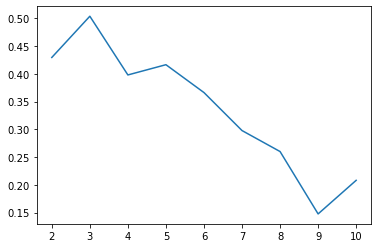

In [269]:
plt.plot(candidate_n_clusters, mse_vals)

In [270]:
clustering_model, *_ = train_clusterer(n_clusters=3)

/opt/conda/envs/earthai/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2693: RuntimeWarning: invalid value encountered in true_divide
  qk = 1.0*qk / np.sum(qk, axis=axis, keepdims=True)


nan
0.0006329849
0.00056986284
0.0006079477
0.0006822848
0.00076864543
0.0006879
0.00073763356
0.00056975416
0.0004901865
0.00047750017
0.0004702088
0.0005047724
0.00047577918
0.00045201718
0.00037682976
0.00052624807
0.00057260983
0.00025738456
0.00019491429
0.00016364286
0.00017070735
0.00015219205
0.00016481851
0.00012406419
0.00013170709
0.0002499331
0.00028331188
0.000114074166
0.00011979723
0.00012215984
0.00012095765
0.00012027516
0.00020285597
0.000121125064
0.000113294875
0.0002610486
0.0001994011
8.7279346e-05
0.000119712495
7.360967e-05
8.186998e-05
7.123295e-05
9.9776495e-05
9.1786525e-05
7.8248995e-05
9.760319e-05
5.2869276e-05
5.0429502e-05
5.863361e-05
4.900883e-05
6.0456478e-05
4.1528125e-05
3.0611518e-05
9.7350625e-05
2.7926279e-05
2.3140448e-05
4.284364e-05
Reached tolerance threshold. Stopping training.


# Cluster Unaugmented Image Data

In [271]:
input_shape, x, y, filenames = read_images(augment_data=False)

Found 248 images belonging to 3 classes.


In [272]:
x = x[y[:, 2] == 1]
filenames = filenames[y[:, 2] == 1]
y = y[y[:, 2] == 1]
y = y[:, -1]

In [273]:
y_pred = clustering_model.predict(x, verbose=0).argmax(1)

In [274]:
sum(y_pred == 0)

68

In [275]:
def display_images(filenames, train_data_dir, figsize=(16, 32), n_cols=10):
    fig, axs = plt.subplots(int(np.ceil(len(filenames) / n_cols)), n_cols, figsize=figsize)
    
    for ax in axs.flatten():
        ax.axis('off')
    
    for ax, f in zip(axs.flatten(), filenames):
        ax.imshow(plt.imread(train_data_dir + f))

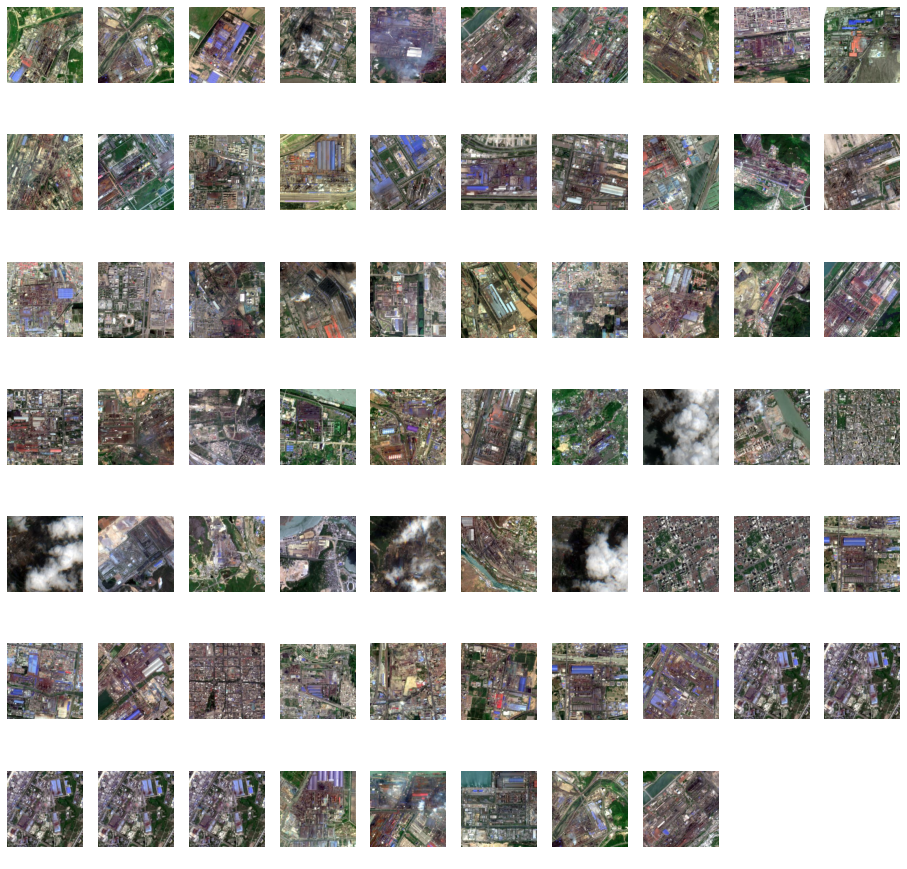

In [276]:
display_images([f for y, f in zip(y_pred, filenames) if y==0], train_data_dir, figsize=(16, 16))

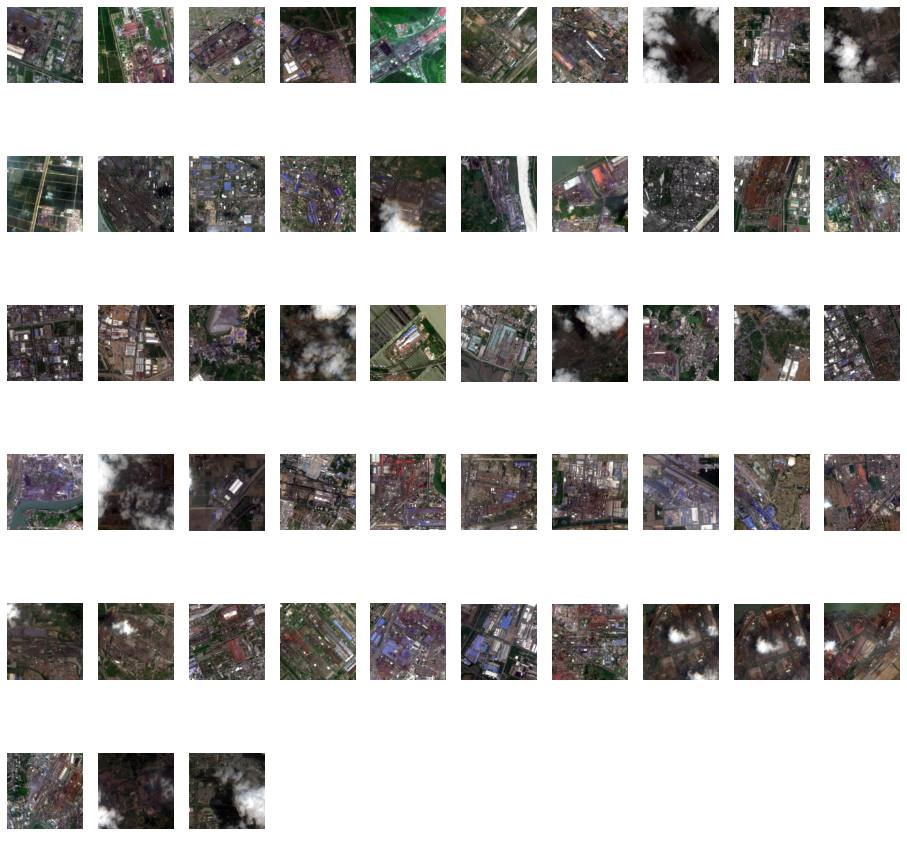

In [277]:
display_images([f for y, f in zip(y_pred, filenames) if y==1], train_data_dir, figsize=(16, 16))

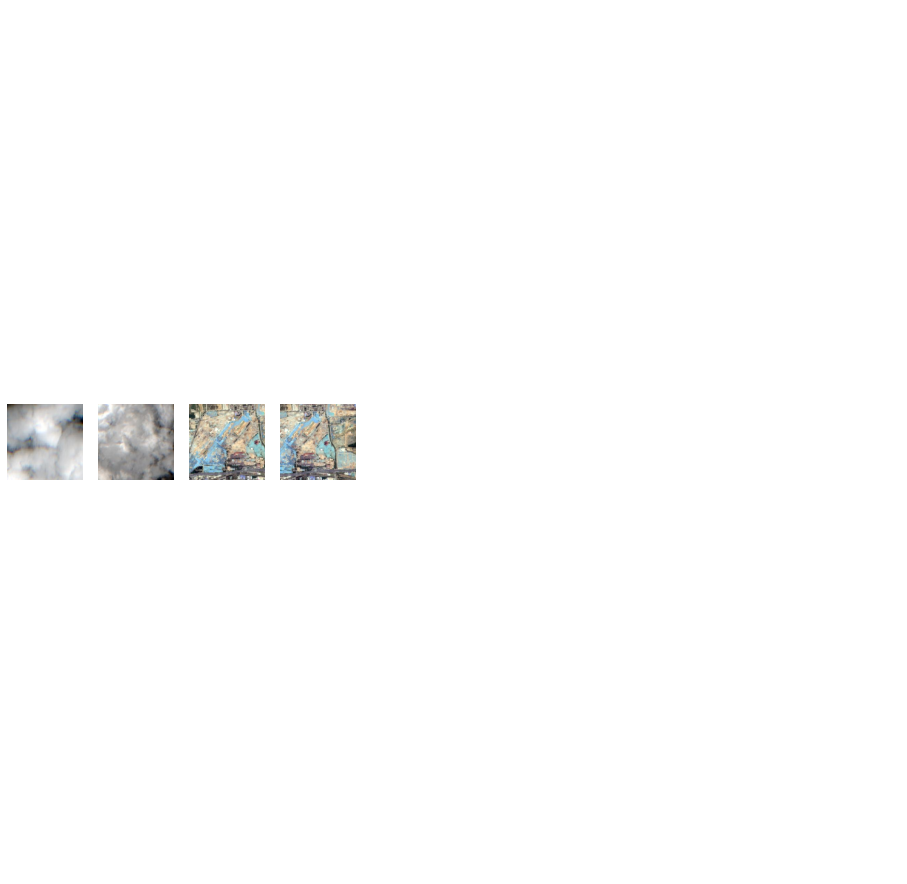

In [278]:
display_images([f for y, f in zip(y_pred, filenames) if y==2], train_data_dir, figsize=(16, 16))